# Log-Level-Classifier: Training

## Description

The following notebook provides a small text classification model trained on OpenShift infrastructure logs. The model is tuned to classify log messages in terms of log level based on the log message sentiment.

## Stages

### Prerequisites

In [ ]:
pip install -Uqq fastai

### Step 1: Prepare how to parse log message and level from Loki queried logs

First things first, we need to write a couple of helper functions to extract logs originating from the following LogQL query against your OpenShift Logging instance:

```sh
export LOKI_PUBLIC_URL=$(k get route lokistack-dev -o jsonpath="{.spec.host}")

logcli --bearer-token="$(oc whoami -t)" \
       --addr "https://${LOKI_PUBLIC_URL}/api/logs/v1/infrastructure" \
       query '{kubernetes_namespace_name=~"openshift.*"}' \
       --output=jsonl \
       --limit=100000 | awk '{print > "file_" NR ".json"}'
```

In [1]:
import json
from pprint import pprint
from logfmt import parse
from fastai.text.all import *

cur_dir = Path.cwd()
samples_dir = cur_dir/'samples'

def read_log_message(f):
    log_file = Path.read_json(f)
    log_line=json.loads(log_file['line'])
    log_data = {}
    for data in parse(io.StringIO(log_line['message'])):
        log_data.update(data)
    return log_data['msg'] if hasattr(log_data, 'msg') else log_line['message']

def read_log_level(f):
    log_file = Path.read_json(f)
    log_line=json.loads(log_file['line'])
    return log_line['level']
    
def get_logs(p):
    return get_files(p, extensions=['.json'])

### Step 2: Setup a DataBlock object and show batch results for verification

Setting up the `Datablock` instance is essential the first step to configure how we are going to read the log files:
1. `get_items` is the callback to read all json files from our `samples/train` directory
2. `get_x` is the callback to parse each log file (i.e. JSON) and extract the message from it. (Assumes `viaQ` format).
3. `get_y` is the callback to parse each log file (i.e. JSON) and extract the emitted level. This is info is used as a label for training.

__Note:__ For debugging one can use either the `DataBlock.summary` or `DataLoaders.show_batch` methods. Both provide valuable info into the pipeline is setup and how the batches look like.

In [2]:
logs = DataBlock(blocks=(TextBlock.from_folder(samples_dir), CategoryBlock),
                 get_items=get_logs,
                 get_y=read_log_level,
                 get_x=read_log_message,
                 splitter=RandomSplitter(valid_pct=0.1))

#logs.summary(cur_dir, bs=4, show_batch=True)
dls=logs.dataloaders(samples_dir, verbose=True)
dls.show_batch(max_n=4)

Found 100000 items
2 datasets of sizes 90000,10000
Setting up Pipeline: read_log_message -> Tokenizer -> Numericalize
Setting up Pipeline: read_log_level -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: Pad_Chunk -- {'pad_idx': 1, 'pad_first': True, 'seq_len': 72}
Setting up after_batch: Pipeline: 


,text,category
0,xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,error
1,xxbos xxup xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,info
2,xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,info
3,xxbos xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxrep,info


### Step 3: Execute the learning and finetuning stage

At this stage we use a pre-trained model (See [AWD_LSTM]()) and setup the `text_classifier_learner` to track `accuracy` as a learning performance metric. The model is fine tuned over 4 epochs.

__Note:__ The training over a dataset of ~100000 log files takes roundabout ~30min per epoch using CPU only as a PyTorch device.

In [3]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.841632,0.735701,0.729700,09:21


epoch,train_loss,valid_loss,accuracy,time
0,0.642573,0.503432,0.812000,34:46
1,0.518432,0.472741,0.821900,40:12
2,0.330702,0.401035,0.826500,40:25
3,0.372324,0.355333,0.841300,39:43


## Step 4: Gather insights on how well the learner did

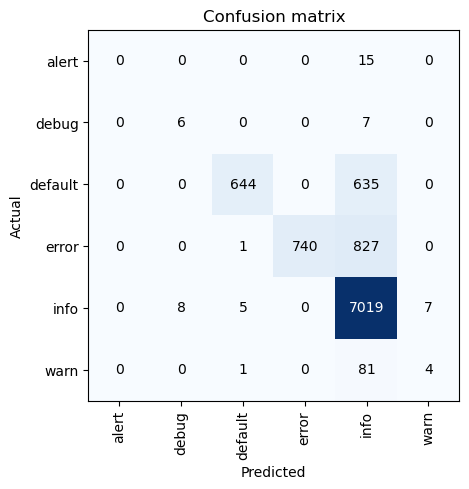

In [5]:
intp = ClassificationInterpretation.from_learner(learn)
intp.plot_confusion_matrix()

### Step 5: Export the model

In [7]:
learn.export('model.pkl')